In [1]:
import pandas as pd

df_not_english_only = pd.read_csv('df_not_english_only.csv')

df_not_english_only.head()

,author_ID,tokenized_post,political_leaning
0,t2_7ramzeng,"['buy', 'show', 'stream', 'including', 'lethal...",right
1,t2_7ramzeng,"['want', 'play', 'bert', 'holy', 'shit', 'base...",right
2,t2_7ramzeng,"['rely', 'external', 'service', 'persistent', ...",right
3,t2_7ramzeng,"['pr', 'specific', 'person', 'usually', 'mean'...",right
4,t2_7ramzeng,"['article', 'intention', 'clear', 'want', 'imp...",right


In [2]:
df_not_english_only.describe()

,author_ID,tokenized_post,political_leaning
count,32030,32030,32030
unique,1295,31983,2
top,t2_fhhbtfe,"['cum', 'cum', 'cum', 'cum', 'cum', 'cum', 'cu...",right
freq,571,48,17454


# TF_IDF vectorization

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_not_english_only['tokenized_post'], df_not_english_only['political_leaning'], test_size=0.2, random_state=42, stratify=df_not_english_only['political_leaning'])

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [32]:
import joblib
# Save the TF-IDF vectorizer and transformed data
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(X_train_tfidf, 'X_train_tfidf.pkl')
joblib.dump(X_test_tfidf, 'X_test_tfidf.pkl')
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

In [14]:
import joblib
# Load TF-IDF vectorizer and transformed data
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
X_train_tfidf = joblib.load('X_train_tfidf.pkl')
X_test_tfidf = joblib.load('X_test_tfidf.pkl')
X_train = joblib.load('X_train.pkl')
X_test = joblib.load('X_test.pkl')
y_train = joblib.load('y_train.pkl')
y_test = joblib.load('y_test.pkl')

# Baseline: Majority Class Classifier

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

majority_classifier = DummyClassifier(strategy="most_frequent")

# Make predictions on the testing data
MCC_y_pred = majority_classifier.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

# Evaluate the model
MCC_accuracy = accuracy_score(y_test, MCC_y_pred)
MCC_report = classification_report(y_test, MCC_y_pred)

print("Accuracy:", MCC_accuracy)
print("Classification Report:\n", MCC_report)


Accuracy: 0.5449578520137371
Classification Report:
               precision    recall  f1-score   support

        left       0.00      0.00      0.00      2915
       right       0.54      1.00      0.71      3491

    accuracy                           0.54      6406
   macro avg       0.27      0.50      0.35      6406
weighted avg       0.30      0.54      0.38      6406



c:\Users\benwi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\benwi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\benwi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

# Logistic Regression Model:

## LR: Hyperparameter tuning

In [34]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define objective function
def objective(trial):
    # Define hyperparameters to tune
    C = trial.suggest_float("C", 0.1, 10.0)
    
    # Initialize logistic regression model with hyperparameters
    logistic_classifier = LogisticRegression(max_iter=1000, C=C)
    
    # Train the logistic regression model
    LR_model = logistic_classifier.fit(X_train_tfidf, y_train)
    
    # Make predictions on the testing data
    LR_y_pred = LR_model.predict(X_test_tfidf)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, LR_y_pred)
    
    return accuracy

# Define Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print best hyperparameters and best accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)


c:\Users\benwi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-05-09 11:42:24,862] A new study created in memory with name: no-name-0bee4520-f757-41cc-8758-cb5c848d3c52
[I 2024-05-09 11:42:29,013] Trial 0 finished with value: 0.8078364033718389 and parameters: {'C': 1.9347611242113556}. Best is trial 0 with value: 0.8078364033718389.
[I 2024-05-09 11:42:34,740] Trial 1 finished with value: 0.8093974399000936 and parameters: {'C': 3.753350727740625}. Best is trial 1 with value: 0.8093974399000936.
[I 2024-05-09 11:42:37,568] Trial 2 finished with value: 0.807211988760537 and parameters: {'C': 1.390547752136076}. Best is trial 1 with value: 0.8093974399000936.
[I 2024-05-09 11:42:40,838] Trial 3 finished with value: 0.8044021230096784 and parameters: {'C': 1.0259022595

Best hyperparameters: {'C': 3.753350727740625}
Best accuracy: 0.8093974399000936


## LR: Saving optimal C hyperparameter

In [35]:
import pickle

# Save the best parameters to a file using pickle
with open('best_params_logistic.pkl', 'wb') as f:
    pickle.dump(study.best_params, f)


In [47]:
import pickle

# Load the best parameters from the saved file
with open('best_params_logistic.pkl', 'rb') as f:
    LR_best_params = pickle.load(f)

In [48]:
LR_best_params

{'C': 3.753350727740625}

## LR: Final Logistic Regression Model

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the logistic regression model with the best hyperparameters
best_C = LR_best_params["C"]  # Get the best value for C
logistic_classifier_optimized = LogisticRegression(max_iter=1000, C=best_C)

# Train the logistic regression model with optimized hyperparameters
LR_model = logistic_classifier_optimized.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
LR_y_pred = LR_model.predict(X_test_tfidf)

# Evaluate the model
LR_accuracy = accuracy_score(y_test, LR_y_pred)
LR_classification_report = classification_report(y_test, LR_y_pred, digits = 4)

print("Accuracy with optimized hyperparameters:", LR_accuracy)
print("Classification Report with optimized hyperparameters:\n", LR_classification_report)


Accuracy with optimized hyperparameters: 0.8093974399000936
Classification Report with optimized hyperparameters:
               precision    recall  f1-score   support

        left     0.8038    0.7688    0.7859      2915
       right     0.8137    0.8433    0.8282      3491

    accuracy                         0.8094      6406
   macro avg     0.8088    0.8060    0.8071      6406
weighted avg     0.8092    0.8094    0.8090      6406



In [37]:
import pickle

# Save LR_accuracy and LR_classification_report to files using pickle
with open('LR_accuracy.pkl', 'wb') as f:
    pickle.dump(LR_accuracy, f)

with open('LR_classification_report.pkl', 'wb') as f:
    pickle.dump(LR_classification_report, f)

In [1]:
import pickle

# Load LR_accuracy from the saved file
with open('LR_accuracy.pkl', 'rb') as f:
    LR_accuracy = pickle.load(f)

# Load LR_classification_report from the saved file
with open('LR_classification_report.pkl', 'rb') as f:
    LR_classification_report = pickle.load(f)

In [8]:
import pickle

# Save the SVM model object to a file using pickle
with open('LR_model.pkl', 'wb') as f:
    pickle.dump(LR_model, f)

In [9]:
import pickle


# Load the saved SVM model object from file using pickle
with open('LR_model.pkl', 'rb') as f:
    LR_model = pickle.load(f)

## LR: 5-fold Cross Validation

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate cross-validation scores for the best model
LR_cv_scores = cross_val_score(logistic_classifier_optimized, X_train_tfidf, y_train, cv=cv, scoring='accuracy')

# Print scores for each fold
print("Cross-validation scores:", LR_cv_scores)
print("Mean accuracy:", LR_cv_scores.mean())

Cross-validation scores: [0.80682927 0.79609756 0.80546341 0.79882927 0.79761905]
Mean accuracy: 0.8009677119628339


In [39]:
import pickle

# Save the LR_cv_scores object to a file using pickle
with open('LR_cv_scores.pkl', 'wb') as f:
    pickle.dump(LR_cv_scores, f)

In [17]:
import pickle

# Save the LR_cv_scores object to a file using pickle
with open('LR_cv_scores.pkl', 'rb') as f:
    LR_cv_scores = pickle.load(f)

## LR: Confusion Matrix

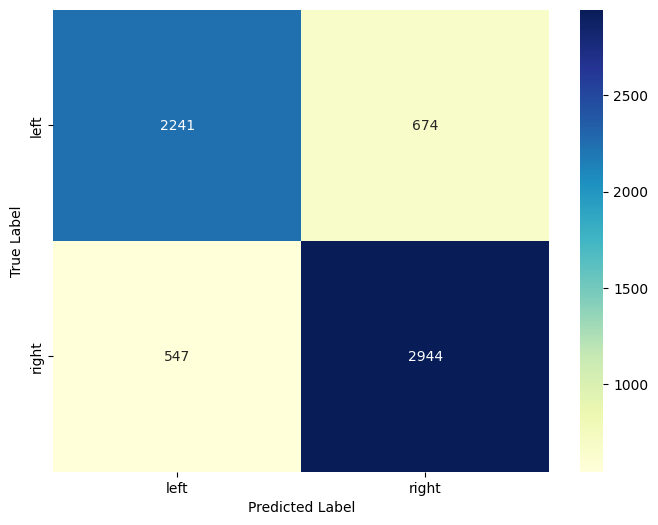

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
LR_confusion_matrix = confusion_matrix(y_test, LR_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(LR_confusion_matrix, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['left', 'right'], yticklabels=['left', 'right'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.title('Confusion Matrix LR model')
plt.show()


## LR: ROC-AUC Curve

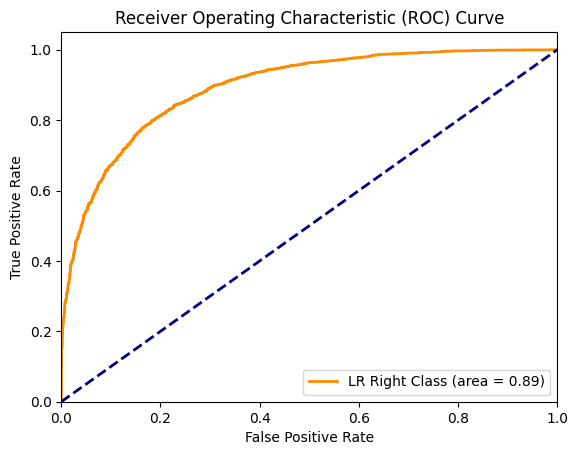

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Encode string labels into numeric labels
label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

# Get predicted probabilities for the positive class
LR_y_prob = LR_model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC using y_test_binary
LR_fpr, LR_tpr, thresholds = roc_curve(y_test_binary, LR_y_prob)
LR_roc_auc = auc(LR_fpr, LR_tpr)  # Compute AUC

# Plot ROC curve
plt.figure()
plt.plot(LR_fpr, LR_tpr, color='darkorange', lw=2, label='LR Right Class (area = %0.2f)' % LR_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [42]:
print(y_test_binary)
print(LR_y_prob)

[1 1 1 ... 1 0 0]
[0.71165601 0.69648812 0.56904591 ... 0.92338415 0.113553   0.38096669]


In [9]:
# Check the classes and their corresponding encoded labels
print(label_encoder.classes_)

['left' 'right']


## LR: Extracting Word Features

In [5]:
import numpy as np

# Assuming LR_model is already trained and tfidf_vectorizer is initialized
# Get the feature names from the tfidf_vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Get values of coefficients
LR_coefficients = LR_model.coef_

# Get indices of top 20 features for each class
LR_top_30_indices_left = LR_coefficients[0].argsort()[-30:][::-1]  # For left-leaning class
LR_top_30_indices_right = (-LR_coefficients[0]).argsort()[-30:][::-1]  # For right-leaning class

# Get top 20 features and their coefficients for each class
LR_top_30_features_left = feature_names[LR_top_30_indices_left]
LR_top_30_features_right = feature_names[LR_top_30_indices_right]
LR_top_30_coefficients_left = LR_coefficients[0][LR_top_30_indices_left]
LR_top_30_coefficients_right = LR_coefficients[0][LR_top_30_indices_right]

In [40]:
import pickle

# Save the LR_top_20_features_left object
with open('LR_top_30_features_left.pkl', 'wb') as f:
    pickle.dump(LR_top_30_features_left, f)

# Save the LR_top_20_coefficients_left object
with open('LR_top_30_coefficients_left.pkl', 'wb') as f:
    pickle.dump(LR_top_30_coefficients_left, f)

In [41]:
# Load the LR_top_20_features_left object
with open('LR_top_30_features_left.pkl', 'rb') as f:
    LR_top_30_features_left = pickle.load(f)

# Load the LR_top_20_coefficients_left object
with open('LR_top_30_coefficients_left.pkl', 'rb') as f:
    LR_top_30_coefficients_left = pickle.load(f)

### LR: Most important word features Left class

In [6]:
# Print top 20 features and their coefficients for left class
print("Top 30 LR features for Left class:")
for feature, coefficient in zip(LR_top_30_features_left, LR_top_30_coefficients_left):
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Top 30 LR features for Left class:
Feature: government, Coefficient: 7.304307652652503
Feature: commie, Coefficient: 7.216143797372895
Feature: cope, Coefficient: 6.69689725519057
Feature: libertarian, Coefficient: 6.529893031232415
Feature: em, Coefficient: 5.915910335659607
Feature: ancap, Coefficient: 5.7867405341249265
Feature: disagree, Coefficient: 5.6227837398883675
Feature: thier, Coefficient: 5.548208252687843
Feature: etc, Coefficient: 5.2862311521798535
Feature: retarded, Coefficient: 5.080264072321432
Feature: reddit, Coefficient: 5.003065235519854
Feature: buddy, Coefficient: 4.941179171276419
Feature: property right, Coefficient: 4.901098918317436
Feature: state, Coefficient: 4.755520569027719
Feature: nyc, Coefficient: 4.73257760428791
Feature: cum cum, Coefficient: 4.707287714334826
Feature: social medium, Coefficient: 4.5929630438917055
Feature: romania, Coefficient: 4.517873040404635
Feature: ought, Coefficient: 4.5061262701089575
Feature: almost, Coefficient: 4.37530

In [43]:
import pickle

# Save the LR_top_20_features_right object
with open('LR_top_30_features_right.pkl', 'wb') as f:
    pickle.dump(LR_top_30_features_right, f)

# Save the LR_top_20_coefficients_right object
with open('LR_top_30_coefficients_right.pkl', 'wb') as f:
    pickle.dump(LR_top_30_coefficients_right, f)

In [44]:
# Load the LR_top_20_features_right object
with open('LR_top_30_features_right.pkl', 'rb') as f:
    LR_top_30_features_right = pickle.load(f)

# Load the LR_top_20_coefficients_right object
with open('LR_top_30_coefficients_right.pkl', 'rb') as f:
    LR_top_30_coefficients_right = pickle.load(f)

### LR: Most important word features Right class

In [45]:
# Print top 20 features and their coefficients for right class
print("Top 30 LR features for Right class:")
for feature, coefficient in zip(LR_top_30_features_right, LR_top_30_coefficients_right):
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Top 30 LR features for Right class:
Feature: orthodox, Coefficient: -6.417001189617485
Feature: empathy, Coefficient: -6.3884950433984935
Feature: vietnamese, Coefficient: -6.3147427101085905
Feature: anarchist, Coefficient: -6.179924437965975
Feature: council, Coefficient: -5.758517792798797
Feature: honestly, Coefficient: -5.439792524965986
Feature: fucking, Coefficient: -5.294581025953382
Feature: auch, Coefficient: -5.274910017637294
Feature: mean, Coefficient: -5.00897833444766
Feature: imperialism, Coefficient: -4.9264584165714504
Feature: comrade, Coefficient: -4.815142587033931
Feature: pandemic, Coefficient: -4.757460950433941
Feature: som, Coefficient: -4.627915281730646
Feature: favourite, Coefficient: -4.507217291322908
Feature: yo, Coefficient: -4.465969365441714
Feature: bernie, Coefficient: -4.442791102105768
Feature: skin, Coefficient: -4.434157509428534
Feature: doesnt, Coefficient: -4.337687078477516
Feature: republican, Coefficient: -4.334659872122973
Feature: realis

### LR: Figure show Left and Right class features

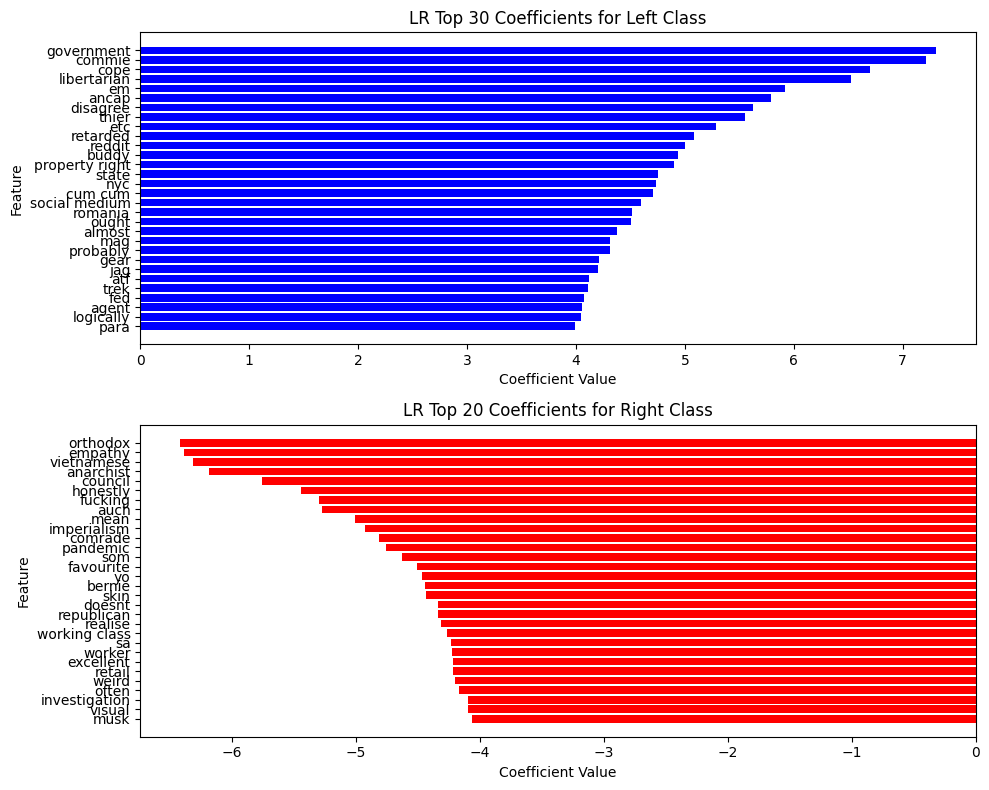

In [46]:
# Reverse the order of features and coefficients
LR_top_30_features_left = LR_top_30_features_left[::-1]
LR_top_30_coefficients_left = LR_top_30_coefficients_left[::-1]

LR_top_30_features_right = LR_top_30_features_right[::-1]
LR_top_30_coefficients_right = LR_top_30_coefficients_right[::-1]

# Create subplots for left and right classes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot top 20 coefficients for left class
axes[0].barh(LR_top_30_features_left, LR_top_30_coefficients_left, color='blue')
axes[0].set_title('LR Top 30 Coefficients for Left Class')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Feature')

# Plot top 20 coefficients for right class
axes[1].barh(LR_top_30_features_right, LR_top_30_coefficients_right, color='red')
axes[1].set_title('LR Top 20 Coefficients for Right Class')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Support Vector Machine Model:

## SVM: Hyperparameter tuning

In [45]:
import optuna
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Define objective function
def objective(trial):
    # Define hyperparameters to tune
    C = trial.suggest_float("C", 0.1, 10.0)
    #gamma = trial.suggest_float("gamma", 0.001, 1.0)
    
    # Initialize SVM classifier with hyperparameters
    svm_classifier = SVC(kernel='linear', C=C) # gamma=gamma
    
    # Train the SVM model
    SVM_model = svm_classifier.fit(X_train_tfidf, y_train)
    
    # Make predictions on the testing data
    SVM_y_pred = SVM_model.predict(X_test_tfidf)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, SVM_y_pred)
    
    return accuracy

# Define Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Print best hyperparameters and best accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)


[I 2024-05-09 11:45:02,845] A new study created in memory with name: no-name-787a9863-a3f1-483d-a1d7-2ccfeccc4bb4
[I 2024-05-09 12:39:05,145] Trial 0 finished with value: 0.8064314704964096 and parameters: {'C': 2.2011379648383858}. Best is trial 0 with value: 0.8064314704964096.
[I 2024-05-09 13:45:02,268] Trial 1 finished with value: 0.797377458632532 and parameters: {'C': 4.457037455414321}. Best is trial 0 with value: 0.8064314704964096.
[I 2024-05-09 15:12:31,341] Trial 2 finished with value: 0.7906650015610365 and parameters: {'C': 9.805324632546407}. Best is trial 0 with value: 0.8064314704964096.
[I 2024-05-09 16:17:49,950] Trial 3 finished with value: 0.7967530440212302 and parameters: {'C': 3.8277372833465604}. Best is trial 0 with value: 0.8064314704964096.
[I 2024-05-09 17:36:30,102] Trial 4 finished with value: 0.7928504527005932 and parameters: {'C': 6.679133214853944}. Best is trial 0 with value: 0.8064314704964096.


Best hyperparameters: {'C': 2.2011379648383858}
Best accuracy: 0.8064314704964096


### SVM: Saving optimal C hyperparameter

In [46]:
import pickle

# Save the best parameters to a file using pickle
with open('best_params_SVM.pkl', 'wb') as f:
    pickle.dump(study.best_params, f)

In [49]:
import pickle

# Load the best parameters from the saved file
with open('best_params_SVM.pkl', 'rb') as f:
    SVM_best_params = pickle.load(f)

In [50]:
SVM_best_params

{'C': 2.2011379648383858}

## SVM: Final SVM Model

In [21]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Initialize the SVM model with best hyperparameters
svm_classifier = SVC(kernel='linear', C=SVM_best_params["C"])

# Train the SVM model
SVM_model = svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the testing data
SVM_y_pred = SVM_model.predict(X_test_tfidf)

# Evaluate the model
SVM_accuracy = accuracy_score(y_test, SVM_y_pred)
SVM_classification_report = classification_report(y_test, SVM_y_pred, digits = 4)

print("Accuracy:", SVM_accuracy)
print("Classification Report:\n", SVM_classification_report)

Accuracy: 0.8064314704964096
Classification Report:
               precision    recall  f1-score   support

        left     0.7988    0.7681    0.7831      2915
       right     0.8124    0.8384    0.8252      3491

    accuracy                         0.8064      6406
   macro avg     0.8056    0.8033    0.8042      6406
weighted avg     0.8062    0.8064    0.8061      6406



In [22]:
import pickle

# Save the accuracy to a file
with open('SVM_y_pred.pkl', 'wb') as f:
    pickle.dump(SVM_y_pred, f)

In [27]:
import pickle

# Load the accuracy from the saved file
with open('SVM_y_pred.pkl', 'rb') as f:
    SVM_y_pred = pickle.load(f)

In [9]:
import pickle

# Save the accuracy to a file
with open('SVM_accuracy.pkl', 'wb') as f:
    pickle.dump(SVM_accuracy, f)

# Save the classification report to a file
with open('SVM_classification_report.pkl', 'wb') as f:
    pickle.dump(SVM_classification_report, f)

In [47]:
import pickle

# Load the accuracy from the saved file
with open('SVM_accuracy.pkl', 'rb') as f:
    loaded_accuracy = pickle.load(f)

# Load the classification report from the saved file
with open('SVM_classification_report.pkl', 'rb') as f:
    loaded_classification_report = pickle.load(f)

### SVM: Saving Final SVM Model

In [50]:
import pickle

# Save the SVM model object to a file using pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(SVM_model, f)


In [20]:
import pickle

# Load the saved SVM model object from file using pickle
with open('svm_model.pkl', 'rb') as f:
    SVM_model = pickle.load(f)

In [48]:
print("Accuracy (Loaded Model):", loaded_accuracy)
print("Classification Report (Loaded Model):\n", loaded_classification_report)

Accuracy (Loaded Model): 0.8064314704964096
Classification Report (Loaded Model):
               precision    recall  f1-score   support

        left       0.80      0.77      0.78      2915
       right       0.81      0.84      0.83      3491

    accuracy                           0.81      6406
   macro avg       0.81      0.80      0.80      6406
weighted avg       0.81      0.81      0.81      6406



## SVM: 5-fold Cross Validation

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Define 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
SVM_cv_scores = cross_val_score(SVM_model, X_train_tfidf, y_train, cv=cv, scoring='accuracy')

# Print scores for each fold
print("Cross-validation scores:", SVM_cv_scores)
print("Mean accuracy:", SVM_cv_scores.mean())

Cross-validation scores: [0.80507317 0.79395122 0.79473171 0.78907317 0.79156909]
Mean accuracy: 0.7948796709887473


In [52]:
import pickle

# Save the SVM_cv_scores object to a file using pickle
with open('svm_cv_scores.pkl', 'wb') as f:
    pickle.dump(SVM_cv_scores, f)


In [49]:
import pickle

# Load the saved SVM_cv_scores object from file using pickle
with open('svm_cv_scores.pkl', 'rb') as f:
    SVM_cv_scores = pickle.load(f)

# Print loaded scores
print("SVM cross-validation scores:", SVM_cv_scores)
print("SVM mean accuracy:", SVM_cv_scores.mean())


SVM cross-validation scores: [0.80507317 0.79395122 0.79473171 0.78907317 0.79156909]
SVM mean accuracy: 0.7948796709887473


## SVM: Confusion Matrix 

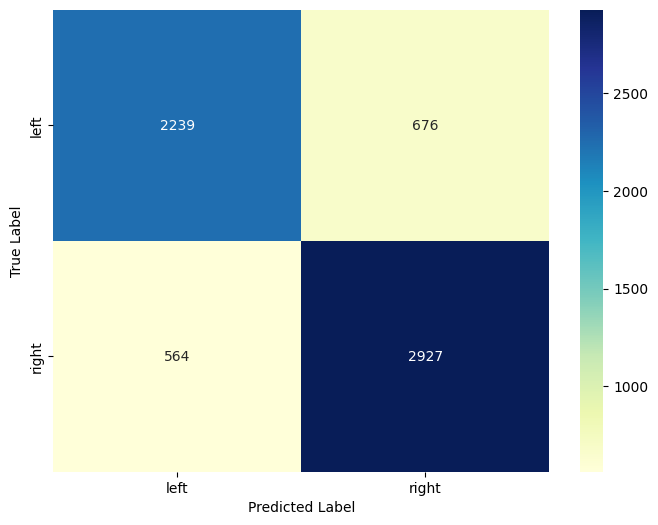

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
SVM_cm = confusion_matrix(y_test, SVM_y_pred)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(SVM_cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['left', 'right'], yticklabels=['left', 'right'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.title('Confusion Matrix SVM model')
plt.show()

## SVM: ROC-AUC

Encoded classes:  ['left' 'right']


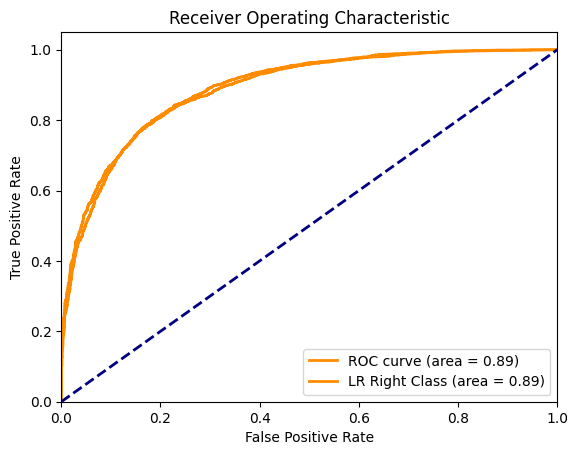

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Encode string labels into numeric labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Check the classes to ensure the encoding is correct
print("Encoded classes: ", label_encoder.classes_)

# Get decision function scores for ROC curve
SVM_y_scores = SVM_model.decision_function(X_test_tfidf)

# Compute ROC curve and ROC area with the encoded labels
SVM_fpr, SVM_tpr, threshold = roc_curve(y_test_encoded, SVM_y_scores)
SVM_roc_auc = auc(SVM_fpr, SVM_tpr)

# Plotting ROC curve
plt.figure()
plt.plot(SVM_fpr, SVM_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % SVM_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [43]:
print(SVM_y_scores)
print(y_test_encoded)

[ 1.17988588  0.76004283  0.23045094 ...  1.61187176 -1.53329144
 -0.77833345]
[1 1 1 ... 1 0 0]


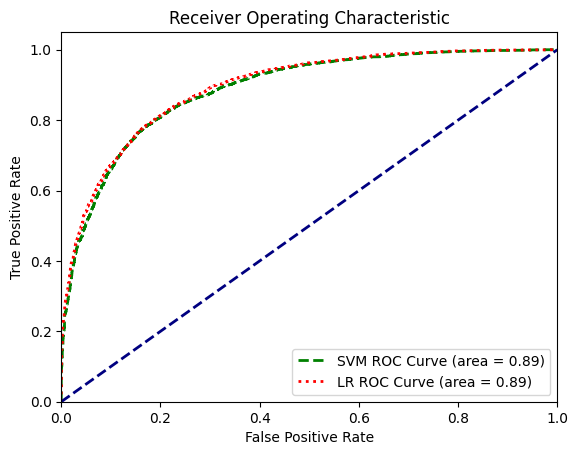

In [45]:
# Plotting ROC curve
plt.figure()
plt.plot(SVM_fpr, SVM_tpr, color='green', lw=2, linestyle = 'dashed', label='SVM ROC Curve (area = %0.2f)' % SVM_roc_auc)
plt.plot(LR_fpr, LR_tpr, color='red', lw=2, linestyle = 'dotted', label='LR ROC Curve (area = %0.2f)' % LR_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle

# Save the objects using pickle
with open('roc_curve_data.pkl', 'wb') as file:
    pickle.dump((SVM_fpr, SVM_tpr, thresholds, SVM_roc_auc), file)

In [13]:
# Load the objects from the pickle file
with open('roc_curve_data.pkl', 'rb') as file:
    fpr, tpr, thresholds, roc_auc = pickle.load(file)


FileNotFoundError: [Errno 2] No such file or directory: 'roc_curve_data.pkl'

In [ ]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## SVM: Extracting Word Features

In [24]:
import numpy as np

# Get the feature names from the tfidf_vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Get the coefficients of the SVM model
SVM_coefficients = SVM_model.coef_

# Convert the coefficients to a dense array if using sparse matrix
SVM_coefficients_dense = SVM_coefficients.toarray()

# Get the absolute values of the coefficients
SVM_abs_coefficients = np.abs(SVM_coefficients_dense)

# Get the indices of positive and negative coefficients
positive_indices = np.where(SVM_coefficients_dense > 0)
negative_indices = np.where(SVM_coefficients_dense < 0)

# Sort positive and negative coefficients separately
top_positive_indices = np.argsort(SVM_abs_coefficients[positive_indices])[::-1][:30]
top_negative_indices = np.argsort(SVM_abs_coefficients[negative_indices])[::-1][:30]

# Get the top positive and negative coefficients and their corresponding features
SVM_top_Left_features = feature_names[positive_indices[1][top_positive_indices]]
SVM_top_Left_coefficients = SVM_coefficients_dense[positive_indices[0][top_positive_indices], positive_indices[1][top_positive_indices]]

SVM_top_Right_features = feature_names[negative_indices[1][top_negative_indices]]
SVM_top_Right_coefficients = SVM_coefficients_dense[negative_indices[0][top_negative_indices], negative_indices[1][top_negative_indices]]



In [34]:
import pickle

# Save the SVM_top_Left_features object
with open('SVM_top_Left_features.pkl', 'wb') as f:
    pickle.dump(SVM_top_Left_features, f)

# Save the SVM_top_Left_coefficients object
with open('SVM_top_Left_coefficients.pkl', 'wb') as f:
    pickle.dump(SVM_top_Left_coefficients, f)

In [ ]:
# Load the SVM_top_Left_features object
with open('SVM_top_Left_features.pkl', 'rb') as f:
    SVM_top_Left_features = pickle.load(f)

# Load the SVM_top_Left_coefficients object
with open('SVM_top_Left_coefficients.pkl', 'rb') as f:
    SVM_top_Left_coefficients = pickle.load(f)

### SVM: Most important word features Left class

In [25]:
# Print the top positive coefficients and features
print("Top 30 SVM features for Left class:")
for feature, coefficient in zip(SVM_top_Left_features, SVM_top_Left_coefficients):
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Top 30 SVM features for Left class:
Feature: cope, Coefficient: 5.466003469346195
Feature: commie, Coefficient: 5.343851779895977
Feature: government, Coefficient: 4.797354905410731
Feature: disagree, Coefficient: 4.651955792156134
Feature: etc, Coefficient: 4.6396719959196915
Feature: ancap, Coefficient: 4.623430745169582
Feature: thier, Coefficient: 4.5405521971543665
Feature: retarded, Coefficient: 4.213685620853849
Feature: nyc, Coefficient: 4.213238012715049
Feature: libertarian, Coefficient: 4.16706890074616
Feature: social medium, Coefficient: 4.042743275638585
Feature: em, Coefficient: 3.8620474380020657
Feature: pray, Coefficient: 3.810690740899119
Feature: almost, Coefficient: 3.577815600426899
Feature: buddy, Coefficient: 3.5733363133311604
Feature: reddit, Coefficient: 3.5505190930009434
Feature: wir, Coefficient: 3.5142325013248357
Feature: jag, Coefficient: 3.482000466587335
Feature: trek, Coefficient: 3.4543906970817613
Feature: property right, Coefficient: 3.44714926679

In [38]:
SVM_top_Left_features

array(['cope', 'commie', 'government', 'disagree', 'etc', 'ancap',
       'thier', 'retarded', 'nyc', 'libertarian', 'social medium', 'em',
       'pray', 'almost', 'buddy', 'reddit', 'wir', 'jag', 'trek',
       'property right', 'probably', 'logically', 'agent', 'romania',
       'self defense', 'ought', 'frankly', 'atf', 'amendment', 'state'],
      dtype=object)

In [35]:
import pickle

# Save the SVM_top_Right_features object
with open('SVM_top_Right_features.pkl', 'wb') as f:
    pickle.dump(SVM_top_Right_features, f)

# Save the SVM_top_Right_coefficients object
with open('SVM_top_Right_coefficients.pkl', 'wb') as f:
    pickle.dump(SVM_top_Right_coefficients, f)

In [36]:
# Load the SVM_top_Right_features object
with open('SVM_top_Right_features.pkl', 'rb') as f:
    SVM_top_Right_features = pickle.load(f)

# Load the SVM_top_Right_coefficients object
with open('SVM_top_Right_coefficients.pkl', 'rb') as f:
    SVM_top_Right_coefficients = pickle.load(f)

### SVM: Most important word features Right class

In [26]:
# Print the top negative coefficients and features
print("Top 30 SVM features for Right class:")
for feature, coefficient in zip(SVM_top_Right_features, SVM_top_Right_coefficients):
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Top 30 SVM features for Right class:
Feature: vietnamese, Coefficient: -5.854791381462268
Feature: comrade, Coefficient: -5.061277710265336
Feature: empathy, Coefficient: -4.774681177112979
Feature: anarchist, Coefficient: -4.752302057941486
Feature: orthodox, Coefficient: -4.476842742809636
Feature: honestly, Coefficient: -4.453983333307372
Feature: auch, Coefficient: -4.130549448472969
Feature: fucking, Coefficient: -4.034656201319797
Feature: imperialism, Coefficient: -4.003390719714981
Feature: favourite, Coefficient: -3.984013660352456
Feature: yo, Coefficient: -3.97810525972184
Feature: working class, Coefficient: -3.614986176944088
Feature: excellent, Coefficient: -3.61337069531194
Feature: musk, Coefficient: -3.6122898919228716
Feature: pandemic, Coefficient: -3.554502081830336
Feature: doesnt, Coefficient: -3.5383641562573027
Feature: mean, Coefficient: -3.5364535960640446
Feature: bernie, Coefficient: -3.521150678428998
Feature: retail, Coefficient: -3.5172178845868
Feature: 

### SVM: Figure showing most important word features Left and Right class

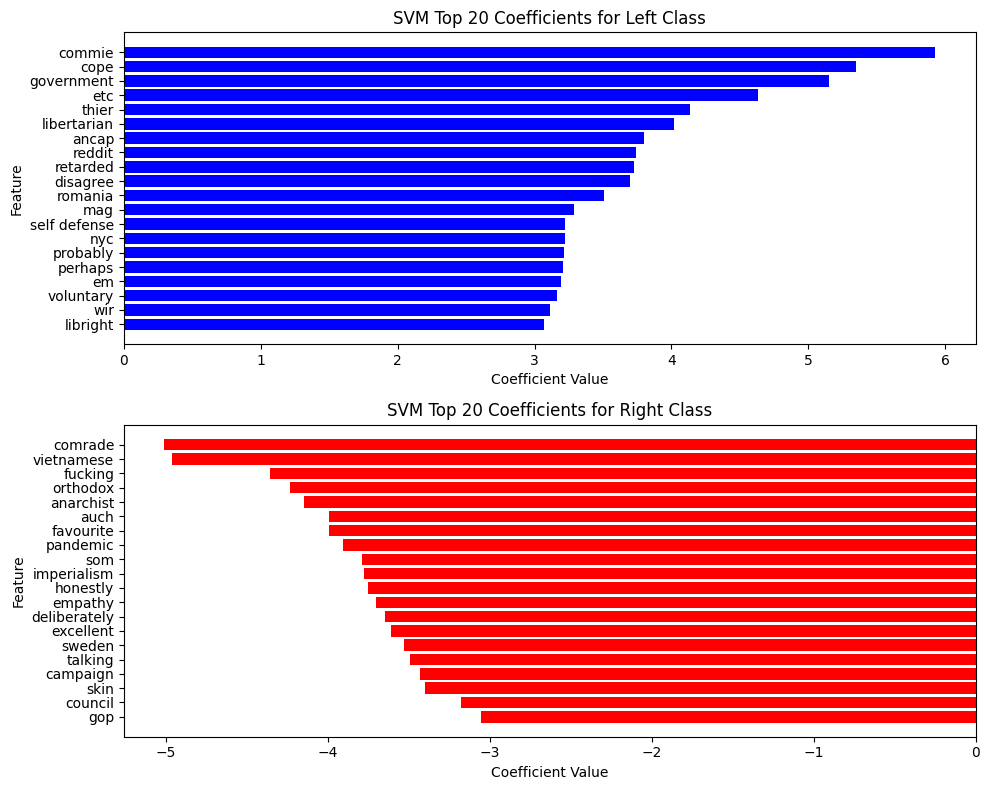

In [40]:
# Reverse the order of features and coefficients
top_Left_features = top_Left_features[::-1]
top_Left_coefficients = top_Left_coefficients[::-1]

top_Right_features = top_Right_features[::-1]
top_Right_coefficients = top_Right_coefficients[::-1]

# Create subplots for left and right classes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot top 10 coefficients for left class
axes[0].barh(top_Left_features, top_Left_coefficients, color='blue')
axes[0].set_title('SVM Top 20 Coefficients for Left Class')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Feature')

# Plot top 10 coefficients for right class
axes[1].barh(top_Right_features, top_Right_coefficients, color='red')
axes[1].set_title('SVM Top 20 Coefficients for Right Class')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
import numpy as np

# Cross-validation scores
lr_scores = [0.8068, 0.7961, 0.8055, 0.7988, 0.7976]
svm_scores = [0.8051, 0.7940, 0.7947, 0.7891, 0.7916]
fasttext_scores = [0.8658, 0.8486, 0.8618, 0.8579, 0.8329]

# Combine scores and model names
all_scores = np.concatenate([lr_scores, svm_scores, fasttext_scores])
models = ['Logistic Regression'] * len(lr_scores) + ['Support Vector Machine'] * len(svm_scores) + ['fastText'] * len(fasttext_scores)


In [8]:
import scipy.stats as stats

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(lr_scores, svm_scores, fasttext_scores)

print("ANOVA Results:")
print(f"F-value: {f_value:.4f}")
print(f"P-value: {p_value:.4f}")


ANOVA Results:
F-value: 66.6500
P-value: 0.0000


In [12]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Combine scores and model names
all_scores = np.concatenate([lr_scores, svm_scores, fasttext_scores])
models = ['Logistic Regression'] * len(lr_scores) + ['Support Vector Machine'] * len(svm_scores) + ['fastText'] * len(fasttext_scores)

# Create DataFrame
df = pd.DataFrame({'Scores': all_scores, 'Model': models})

# Perform one-way ANOVA
model = ols('Scores ~ Model', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Results:")
print(anova_table)


ANOVA Results:
            sum_sq    df          F        PR(>F)
Model     0.010348   2.0  66.649998  3.173174e-07
Residual  0.000932  12.0        NaN           NaN


In [10]:
pip install statsmodels

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.9 MB 1.8 MB/s eta 0:00:06
   - -------------------------------------- 0.3/9.9 MB 2.9 MB/s eta 0:00:04
   -- ------------------------------------- 0.5/9.9 MB 3.4 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/9.9 MB 3.9 MB/s eta 0:00:03
   ---- ----------------------------------- 1.0/9.9 MB 4.0 MB/s eta 0:00:03
   ---- ----------------------------------- 1.0/9.9 MB 4.0 MB/s eta 0:00:03
   ---- ----------------------------------- 1.0/9.9 MB 4.0 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/9.9 MB 2.9 MB/s eta 0:00:04
   ------- -------------------------------- 1.8/9.9 MB 4.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.0/9.9 MB 4.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.1/9.9 MB 4.1 MB/s eta 0:00:02
   --------- -------------

In [11]:
import statsmodels.stats.multicomp as mc

# Create a list of all your model performance scores
scores = [lr_scores, svm_scores, fasttext_scores]  # Replace with your actual scores

# Create a list of group labels corresponding to each set of scores
groups = ['Logistic Regression'] * len(lr_scores) + ['Support Vector Machine'] * len(svm_scores) + ['fastText'] * len(fasttext_scores)

# Perform Tukey's HSD test
tukey_results = mc.MultiComparison(np.concatenate(scores), groups).tukeyhsd()

# Print the results
print(tukey_results)


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
   Logistic Regression Support Vector Machine  -0.0061 0.5393 -0.0209 0.0088  False
   Logistic Regression               fastText   0.0524    0.0  0.0376 0.0673   True
Support Vector Machine               fastText   0.0585    0.0  0.0436 0.0734   True
-----------------------------------------------------------------------------------
